<a href="https://colab.research.google.com/github/MissTiny/Graph_Mining_Node_Edge_K-Mean_Clustering/blob/Algorithm2(GA)/GA_K_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports.

In [3]:
import json
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import math

Reading Signed network.

In [4]:
signed_network = nx.read_weighted_edgelist('soc-sign-Slashdot090221.txt.gz', comments='#', create_using=nx.DiGraph(), nodetype = int)

Reading node features.

In [5]:
node_features ={}
no_of_features = 100
line_no = 0
with open("embedded-soc-sign-slashdot") as nf: 
    Lines = nf.readlines() 
    for line in Lines:
        #skip first line
        if line_no > 0:
            # splitting by space
            values = line.split()
            values = values[:no_of_features+1]
            index = 0
            # reading node features
            for val in values:
                if index == 0:
                    # reading nodeIds for first time
                    if line_no == 1:
                        node_features["nodeId"] = [int(val)]
                    else:
                        node_features["nodeId"].append(int(val))
                
                elif index > 0:
                    # reading features for the first time
                    if line_no == 1:
                        node_features["feature"+str(index)] = [float(val)]
                    else:
                        node_features["feature"+str(index)].append(float(val))
                index+=1
        line_no += 1

node_features_df = pd.DataFrame(node_features)

Determining optimal number of clusters or number of active centers using elbow method.

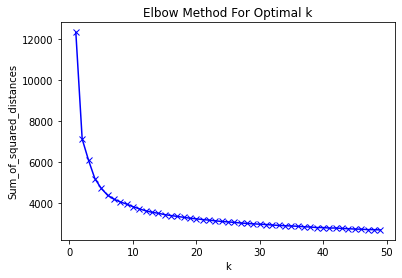

In [ ]:
# To give equal importance to all features, we need to scale the continuous features. 
# We will be using scikit-learn’s MinMaxScaler as the feature matrix is a mix of binary and continuous features . 
mms = MinMaxScaler()
mms.fit(node_features_df)
node_features_df_transformed = mms.transform(node_features_df)

Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=-1)
    km = km.fit(node_features_df_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above elbow plot, it looks like optimal value of K is 7.

In [6]:
K = 7

Extracting node Ids.

In [7]:
nodeIds = list(node_features_df["nodeId"])

Function to calculate profile similarities.

In [8]:
# based on euclidean distance
def profSimilarity(nodeId, active_center, active_centers):
    nodeId_index = nodeIds.index(nodeId)
    ac_index = active_centers.index(active_center)
    # setting to 1 to avoid division by zero error
    sum = 1
    for i in range(0, no_of_features):
        
        sq_diff = (node_features_df["feature"+str(i+1)][nodeId_index] - node_features_df["feature"+str(i+1)][ac_index])**2
        sum += sq_diff

    # returning inverse as high value means less similarity.
    return 1/math.sqrt(sum)

Function to determine whether edge exists or not.

In [9]:
def edgeExists(nodeId, active_center):
    if signed_network.has_edge(nodeId, active_center) or signed_network.has_edge(active_center, nodeId):
        return 1
    else:
        return 0

Function to calculate strength of ties.

In [10]:
def strengthOfTies(nodeId, active_center):
    sum = 0
    for degree in list(dict(signed_network.degree([nodeId, active_center])).values()):
        sum+=degree
    sum -= 1
    return 1/sum

Function to find residual area (those neighbors of given nodes that are not in the social circle).

In [11]:
def residualArea(x,circle):
    residual = list(signed_network.neighbors(x))
    for re in residual:
        if re in circle:
            residual.remove(re)
    return residual

Function to calculate degree centrality.

In [12]:
def degreeCentrality(x,circle):
    degree = 0
    for c in circle:
        if signed_network.has_edge(x, c) or signed_network.has_edge(c, x):
            degree+=1
    # error if len(circle) = 1
    if len(circle) ==1:
        deg_cen = degree
    else:
        deg_cen = degree/(len(circle)-1)
    return deg_cen

Funtion to discover social circle using K-means.

In [40]:
def algorithm1(nodeIds,active_centers, add_trust_ftr = False):
    social_circles = {}
    nodeIdsWAC = list(set(nodeIds) - set(active_centers))
    for i in range (0, K):
        active_center = active_centers[i]
        social_circles[str(active_center)] = []
    for nodeId in nodeIdsWAC:
        maxS = 0
        # active_center which will be most similar to given node
        selectedAC = -1
        for i in range (0, K):
            active_center = active_centers[i]
            p1 = 0
            p2 = 0
            p3 = 0

            p1 = edgeExists(nodeId, active_center)

            if p1 == 1:
                p2 = profSimilarity(nodeId, active_center,active_centers)
                p3 = strengthOfTies(nodeId, active_center)

                if maxS < p2 + p3:
                    maxS = p2 + p3
                    selectedAC = active_center
    
        if selectedAC != -1:
            social_circles[str(selectedAC)].append(nodeId)
    return social_circles

Initializing variables for Genetic Algorithm.

In [14]:
#center selection
##population size = 40
N = 40
population = []
random.seed(0)

Generating random population (sets of active centers) randomly.

In [15]:
for i in range(0,N):
    selected = random.sample(nodeIds,K)
    if selected not in population:
        population.append(selected)

Algorithm2_part1 takes one group of centers and return the fitness of it.

In [16]:
def algorithm2_part1(pop_n, add_trust_ftr = False):
    Xi = pop_n
    Cij = algorithm1(nodeIds,Xi)
    
    obj=0
    for k in range(0,K):
        #initialize k=1 and obj=0
        xi = Xi[k]
        
        residual =  residualArea(xi,Cij[str(xi)])
        #deg_cen
        deg_cen_C = degreeCentrality(xi,Cij[str(xi)])
        deg_cen_R = degreeCentrality(xi,residual)
        
        #prof_sim
        prof_sim_C = 0
        for c in Cij[str(xi)]:
            prof_sim_C+=profSimilarity(c, xi,Xi)
        prof_sim_C = prof_sim_C/len(Cij)
        
        prof_sim_R = 0
        for r in residual:
            prof_sim_R+=profSimilarity(r, xi,Xi)
        if len(residual) != 0:
            prof_sim_R = prof_sim_R/len(residual)
        
        #str_C
        str_C = 0
        for c in Cij[str(xi)]:
            str_C+= strengthOfTies(c, xi)
        str_C = str_C/len(Cij)
        
        str_R = 0
        for r in residual:
            str_R+= strengthOfTies(r, xi)
        if len(residual) != 0:
             str_R = str_R/len(residual)
       
        
        obj+=deg_cen_C - deg_cen_R + prof_sim_C - prof_sim_R + str_C - str_R
    
    
    return obj/K

Calculating fitness value of generated population.

In [17]:
#initialize n=1 and fitness = 0
fitness=[]
for n in range(0,N):
    #pick up the ith row from X_ij and Cij
    fitness.append(algorithm2_part1(population[n]))

Functions to check the format of generated Q offspring (new set of active centers generated after crossover and mutation).

In [18]:
def check(matrix):
    for i in matrix:
        if len(i)!=8:
            print("error in row: ",i)

Applying Crossover and mutation operation to determine best set of active centers.

In [19]:
# Part two
##Augmented matrix Q containing fitness value for each set of active center
Q=[]
for i in range(0,len(fitness)):
    Qi = population[i].copy()
    Qi.append(fitness[i])
    Q.append(Qi)

In [20]:
# re-sort in descending order
# since there are K elements in each set then we have fitness value at K index
fit_val_index = K
Q_desc= sorted(Q,key=lambda x:x[fit_val_index],reverse=True)

Locally optimum version of GA (convergence quickly but doesn't gurantee best set of active centers w.r.t global context).

In [38]:
def run_local_optimum_ga(add_trust_ftr = False):

    print("Running local optimum Genetic Algorithm for best set of active centers.")
    count = 0
    iteration = 0
    Q_desc_temp = Q_desc.copy()
    max_fit_yet = Q_desc_temp[0][-1]
    current_best_set = []
    current_best_fit = 0
    print("Current best fitness value: ",str(Q_desc_temp[0][-1]))
    print("Current best set of Active Centers:")
    print(Q_desc_temp[0][:K])
    
    while count < 1000000:

        while iteration <10:

            #Select two parent chromosomes let say X1 and X2 from a population with high fitness value
            #########This trunk try to find the best X after crossover###################################################
            
            Q1 = Q_desc_temp[0]
            Q2 = Q_desc_temp[1]

            x1 = Q1[:-1]
            x1_fit = Q1[-1]
                
            x2 = Q2[:-1]
            x2_fit = Q2[-1]

            #crossover_probability = 0.8
            if random.randint(0, 10) < 9:     
                randc_pos = random.randint(1,K)
            
                x1_new = x1[:randc_pos]+x2[randc_pos:]
                x2_new = x2[:randc_pos]+x1[randc_pos:]
                
                x1_new_fit = algorithm2_part1(x1_new, add_trust_ftr)
                x2_new_fit = algorithm2_part1(x2_new, add_trust_ftr)

            else:
                x1_new = x1
                x2_new = x2
                
                x1_new_fit = x1_fit
                x2_new_fit = x2_fit

            max_fit = max(x1_new_fit,x2_new_fit)
                
            if x1_new_fit == max_fit:
                x = x1_new
            elif x2_new_fit == max_fit:
                x = x2_new

            #mutation
            #generate a random position randm_pos [1,k] and rand_id [1,n]
            
            #mutation_probability = 0.2
            if random.randint(0, 10) < 3:     
                randm_pos = random.randint(0,K)
                rand_id = random.choice(nodeIds)
                
                if rand_id in (x[:randm_pos]+x[randm_pos:]):
                    x_new = x
                else:
                    x_new = x[:randm_pos]+[rand_id]+x[randm_pos:]
                
                x_new_fit = algorithm2_part1(x_new, add_trust_ftr)

            else:
              x_new = x
              x_new_fit = max_fit
              
            # replacing the set with least fit value with the new set
            if x_new_fit > Q_desc_temp[-1][-1]:
                Q_desc_temp[-1] = x_new + [x_new_fit]
                Q_desc_temp = sorted(Q_desc_temp,key=lambda x:x[-1],reverse=True)
            
            if Q_desc_temp[0][-1] > max_fit_yet:
                max_fit_yet = Q_desc_temp[0][-1]
                iteration = 0
            else:
                iteration +=1


        if current_best_fit < Q_desc_temp[0][-1]:
            print("Current best fitness value: ",str(Q_desc_temp[0][-1]))
            print("Current best set of Active Centers:")
            print(Q_desc_temp[0][:K])
            current_best_set = Q_desc_temp[0][:K]
            current_best_fit = Q_desc_temp[0][-1]
        
        count+=1
    return current_best_set
 
  


Getting locally optimum social circles without considering link/trust feature.

In [41]:
ac_wo_trust = run_local_optimum_ga()
print("Best Set of Active Centers without trust feature:")
print(ac_wo_trust)
print("Generating Social Circles.")
sc_wo_trust = algorithm1(nodeIds, ac_wo_trust)
print("Social Circles without trust:")
print(sc_wo_trust)

Running local optimum Genetic Algorithm for best set of active centers.
Current best fitness value:  1.5296819383826514
Current best set of Active Centers:
[80783, 79051, 17248, 73570, 43198, 17502, 37519]
Current best fitness value:  1.6108045080118576
Current best set of Active Centers:
[35999, 80783, 79051, 73570, 43198, 43198, 17502]
Best Set of Active Centers without trust feature:
[35999, 80783, 79051, 73570, 43198, 43198, 17502]
Generating Social Circles.
Social Circles without trust:
{'35999': [35998, 68345], '80783': [80782], '79051': [16196], '73570': [43270], '43198': [6096, 11272], '17502': [2791, 5499]}


Globally optimum version of GA (gurantees best set of active centers but convergences slowly).

In [ ]:
def run_global_optimum_ga():
  iteration = 0
  Q_desc_new=[]
  pre_fit = 0

  while iteration <10:
      if (Q_desc_new != []):
          Q_desc = Q_desc_new
          pre_fit = Q_desc[0][-1]
          Q_desc_new = []
          
      for i in range(0,N):
          # print(i)
          #Select two parent chromosomes let say X1 and X2 from a population with high fitness value
          #########This trunk try to find the best X after crossover###################################################
          #assume fitness value > 1 means high

          Q_high = list(filter(lambda x:x[fit_val_index]>1,Q_desc))
          if len(Q_high) >10:
              Q_high = Q_high[:10]
          
          #print(Q_high)
          Q1 = random.choice(Q_high)
          Q2 = random.choice(Q_high)
          #print(Q1,Q2)
          x1 = Q1[:-1]
          x1_fit = Q1[-1]
          x2 = Q2[:-1]
          x2_fit = Q2[-1]
          while x2 == x1:
              x2 = random.choice(Q_high)
          #random.seed(0)
          randc_pos = random.randint(1,K)
          
          x1_new = x1[:randc_pos]+x2[randc_pos:]
          x2_new = x2[:randc_pos]+x1[randc_pos:]
          
          x1_new_fit = algorithm2_part1(x1_new)
          x2_new_fit = algorithm2_part1(x2_new)
          
          max_fit = max(x1_fit,x2_fit,x1_new_fit,x2_new_fit)
          
          if(x1_fit == max_fit):
              x = x1
              #print("x1 is the best")
          elif (x2_fit == max_fit):
              x = x2
              #print("x2 is the best")
          elif (x1_new_fit == max_fit):
              x = x1_new
              #print("x1 new is the best")
          else:
              x = x2_new
              #print("x2 new is the best")
  ###################original thought###################################        
  #         x1 = Q_desc[i][:-1]
  #         x2 = Q_desc[i+1][:-1]
          
  #         #cross over
  #         #generate a random int randc_pos
  #         random.seed(0)
  #         randc_pos = randint(1,K)
          
  #         x1_new = x1[:randc_pos]+x2[randc_pos:]
  #         x2_new = x2[:randc_pos]+x1[randc_pos:]
  #########################################################
          #mutation
          #generate a random position randm_pos [1,k] and rand_id [1,n]
          randm_pos = random.randint(1,K)
          rand_id = random.choice(nodeIds)
          
          #x = x1_new
          #x = Q_desc[i]
          #repair chomorosome if values of two alleles of a chromosome occurs
          if rand_id in (x[:randm_pos-1]+x[randm_pos:]):
              x_new =x
          else:
              x_new = x[:randm_pos-1]+[rand_id]+x[randm_pos:]
          
          x_new_fit = algorithm2_part1(x_new)
          # print("This is x_new_fit:", str(x_new_fit),"This is Q_desc[i][-1]",str(Q_desc[i][-1]))
          if (x_new_fit > Q_desc[i][-1]):
              Q_desc_new.append(x_new + [x_new_fit])
              #print("new Q is better")
          else:
              Q_desc_new.append(Q_desc[i])

      Q_desc_new= sorted(Q_desc_new,key=lambda x:x[-1],reverse=True)
      check(Q_desc_new)
      print(Q_desc_new)
      if Q_desc_new[0][-1] == pre_fit:
          iteration +=1
      else:
          iteration = 1
      print("Best fit is ",str(Q_desc_new[0][-1]),", and iteration currently is ", str(iteration))


error in row:  [13123, 79051, 5470, 19042, 43198, 17502, 37519, 1.6735967484974896, 1.8160206273880088]
[[40730, 48925, 17248, 74326, 43198, 17502, 37519, 1.9034521327224259], [13123, 54275, 3051, 56804, 43198, 17502, 37519, 1.8355373968013464], [13123, 34006, 37355, 51330, 43198, 17502, 37519, 1.824865232929076], [13123, 79051, 5470, 19042, 43198, 17502, 37519, 1.6735967484974896, 1.8160206273880088], [40730, 1447, 17248, 73570, 43198, 17502, 37519, 1.787126678596368], [13123, 36719, 3051, 73570, 43198, 17502, 37519, 1.78522820284404], [13123, 34006, 3051, 45568, 43198, 17502, 37519, 1.7820216350361908], [80783, 62094, 37355, 26863, 43198, 17502, 37519, 1.7539619343549595], [40730, 48925, 17248, 73570, 43198, 17502, 37519, 1.7480181143091558], [13123, 34006, 3051, 54193, 52571, 308, 37519, 1.745680605657102], [24675, 79051, 17248, 19042, 43198, 17502, 53765, 1.7342896420660439], [22739, 34006, 3051, 45568, 43198, 17502, 37519, 1.727644582447701], [13123, 34006, 3051, 54193, 52571, 175